In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from glob import glob
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
import os
import copy
import pandas as pd
from PIL import Image
from skimage import io, transform
import random
from tqdm import tqdm
from sklearn.utils import shuffle

In [3]:
from dataloaders.PhotoDataset import PhotoDataset
from models.Vgg16FeatureModel import Vgg16FeatureModel
from models.PasticheModel import PasticheModel

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
dataset_images = "../dataset/train2017/train2017/"
style_image_dir = "images/mosaic.jpg"
image_size = 256
num_workers = 2
batch_size = 8

layers = {
#             '1':"relu1_1",
            '3':"relu1_2",
#             '6':"relu2_1",
            '8':"relu2_2",
#             '11':"relu3_1",
#             '13':"relu3_2",
            '15':"relu3_3",
#             '18':"relu4_1",
#             '20':"relu4_2",
            '22':"relu4_3",
#             '25':"relu5_1",
#             '27':"relu5_2",
#             '29':"relu5_3"
        }
content_layer = "relu3_3"
style_layers = {
    "relu1_2": 1.0,#0.4,
    "relu2_2": 1.0,#0.3,
    "relu3_3": 1.0,#0.2,
    "relu4_3": 1.0,#0.1
}
mean = [0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]    
model_dir="temp2/"

In [6]:
data_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
                             std=std)
    ])

photo_dataset = PhotoDataset(root_dir=dataset_images, transform = data_transform)

dataloader = DataLoader(photo_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=num_workers)

In [7]:
vggfmodel = Vgg16FeatureModel(layers, device)

In [1]:
pastichemodel = PasticheModel()
pastichemodel = pastichemodel.to(device)
optimizer = optim.Adam(pastichemodel.parameters(), lr=0.001, betas=(0.9, 0.999))

NameError: name 'PasticheModel' is not defined

In [ ]:
style_target = vggfmodel.get_style_gram(data_transform(Image.open(style_image_dir).convert('RGB')).unsqueeze(0).to(device))

In [ ]:
def unnormalize_batch(batch):
    n_mean = batch.new_tensor(mean).view(-1, 1, 1)
    n_std = batch.new_tensor(std).view(-1, 1, 1)
    return (batch * n_std) + n_mean

In [ ]:
def normalize_batch(batch):
    n_mean = batch.new_tensor(mean).view(-1, 1, 1)
    n_std = batch.new_tensor(std).view(-1, 1, 1)
    return (batch - n_mean) / n_std

24.41393,646.9032:   0%|          | 0/14786 [00:01<?, ?it/s]

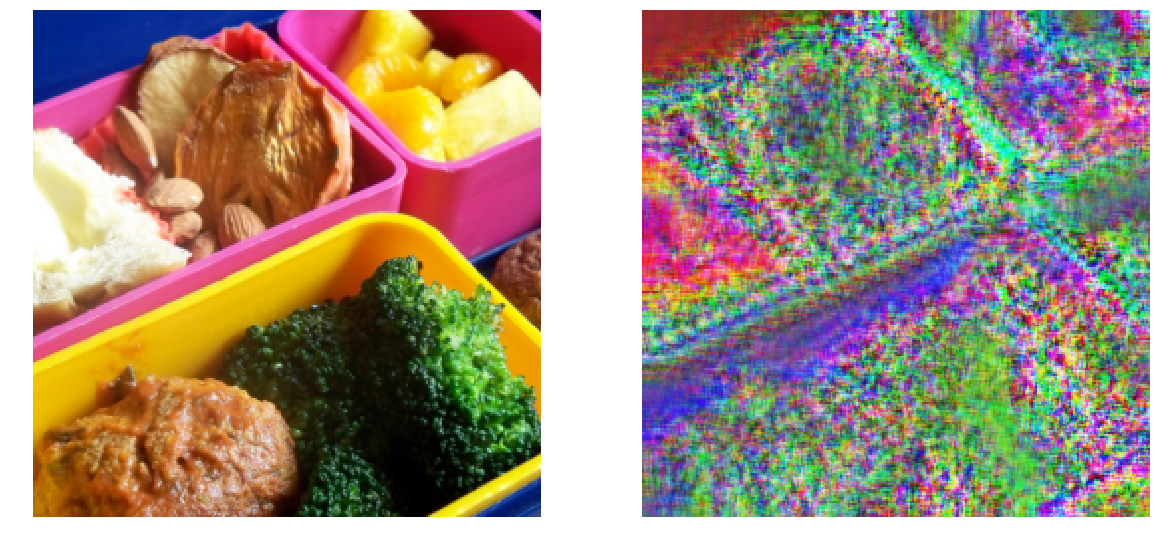

27.701347,6.638621:   7%|▋         | 1000/14786 [12:39<2:56:27,  1.30it/s] 

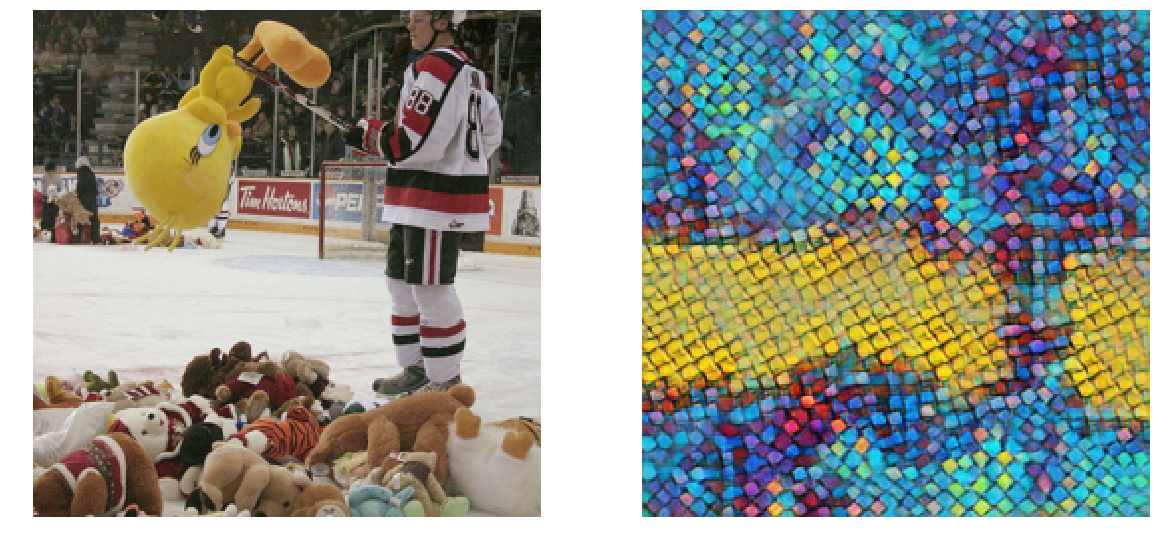

29.605293,3.9506369:  14%|█▎        | 2000/14786 [25:19<2:41:19,  1.32it/s]

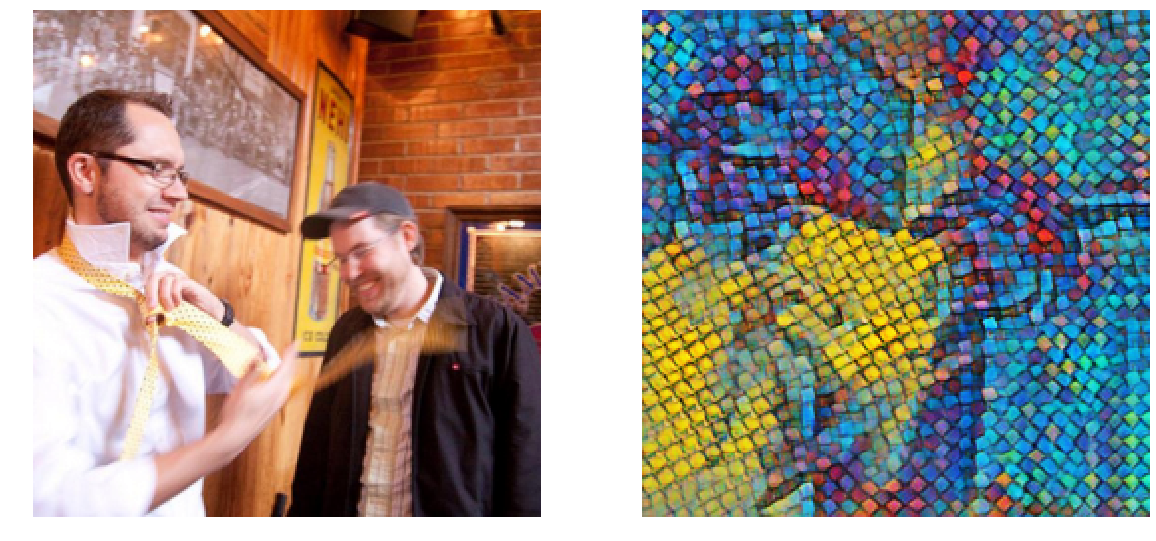

26.133762,4.684161:  15%|█▍        | 2176/14786 [27:32<2:38:46,  1.32it/s] 

In [ ]:
step = 0
step_show = 1000
for i in range(2):
    pbar = tqdm(dataloader)
    for img, img_ids in pbar:
        img = img.to(device)
        features = vggfmodel.get_features(img)
        optimizer.zero_grad()
        output_temp = pastichemodel(img)
        
        output = normalize_batch(output_temp)

        output_features = vggfmodel.get_features(output)

        content_loss = torch.mean((features[content_layer] - output_features[content_layer])**2,(1,2,3))


        style_loss = torch.zeros(img.size()[0]).to(device)
        for key, value in layers.items():
            output_feature = output_features[value]
            output_gram = vggfmodel.gram_batch_matrix(output_feature)

            style_gram = style_target[value]
            style_loss += style_layers[value]*torch.mean(((output_gram - style_gram)**2),(1,2))

        content_mean_loss = torch.mean(content_loss)
        style_mean_loss = 100000*torch.mean(style_loss)

        total_loss = content_mean_loss + style_mean_loss
        prnt_content_loss = str(content_mean_loss.cpu().detach().numpy())
        prnt_style_loss = str(style_mean_loss.cpu().detach().numpy())

        pbar.set_description(prnt_content_loss+","+prnt_style_loss)
        total_loss.backward()
        optimizer.step()
        if step%step_show==0:
            test_org = unnormalize_batch(img)
            test_org = test_org[0].cpu().detach().numpy()*255.0
            test_org = np.moveaxis(test_org, 0, 2)
            im_org = Image.fromarray(np.uint8(test_org))
            
            test_img = output_temp[0].cpu().detach().numpy()*255.0
            test_img = np.moveaxis(test_img, 0, 2)
            im = Image.fromarray(np.uint8(test_img))
            
            f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(20,20))
            ax1.imshow(np.asarray(im_org))
            ax1.axis('off')  
            ax2.imshow(np.asarray(im))
            ax2.axis('off')  
            plt.show()
            torch.save(pastichemodel.state_dict(), model_dir+"pastichemodel-"+str(step)+".pth")
        step+=1

In [13]:
torch.save(pastichemodel.state_dict(), model_dir+"pastichemodel-FINAL.pth")

In [26]:
pastichemodel.load_state_dict(torch.load(model_dir+'pastichemodel-4000.pth'))

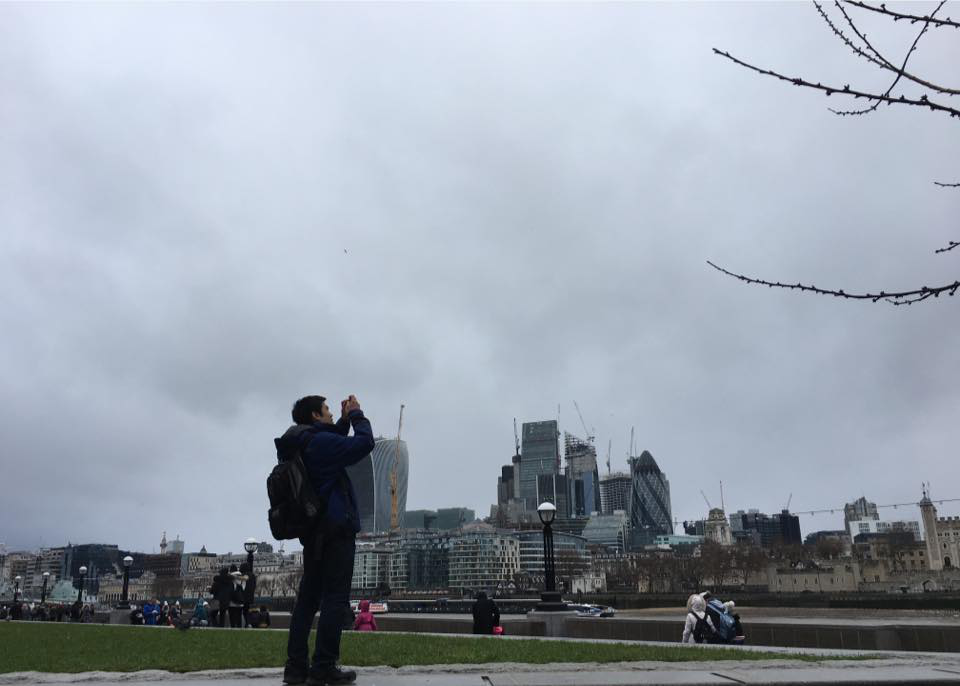

In [27]:
im2 = Image.open("../profile.jpg").convert('RGB')
# im2.thumbnail((682, 512),Image.ANTIALIAS)
im2

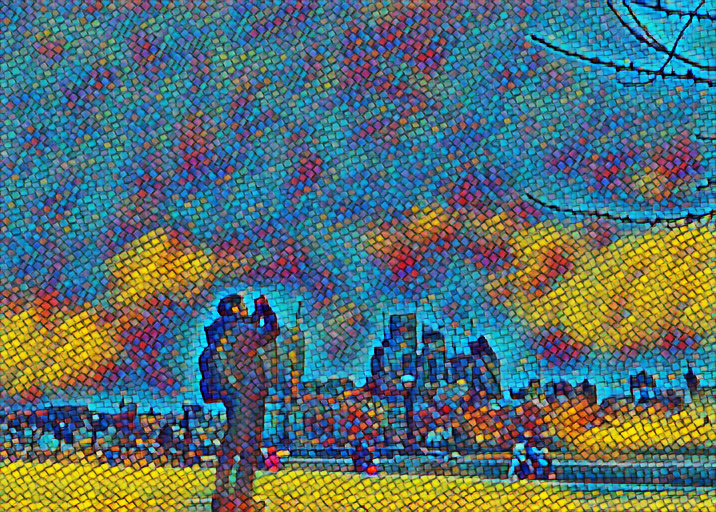

In [28]:
data_transform_2 = transforms.Compose([
        transforms.Resize(512),
#         transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
out2 = data_transform_2(im2)
res = pastichemodel(out2.unsqueeze(0).to(device))
res_img = res[0].cpu().detach().numpy()*255.0
res_img = np.moveaxis(res_img, 0, 2)
res_im = Image.fromarray(np.uint8(res_img))
res_im